承接 1210_00_start.py

參考: 
0. 一直不漂亮的進度條
 - 
https://stackoverflow.com/questions/7715594/how-to-reset-cursor-to-the-beginning-of-the-same-line-in-python
0. 想要關掉 jupyter 後仍運行
 - http://liuchengxu.org/pelican-blog/jupyter-notebook-tips.html
0. 未用: 
 - https://github.com/Deepayan137/K-svd

In [19]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [20]:
import time

In [21]:
class OMP_SVD: #兩個 class 合併成 sparse codeing 吧
    def __init__(self, dictionary, dataAll, letter):
        """  """
        self.D = np.matrix(dictionary.copy())
        self.X = np.matrix(dataAll.copy())
        self.L = letter
        
        self.atomNum = self.D.shape[1]
        
        #print( "長度", D_org.shape[0], "的 有", D_org.shape[1], "個")
        print( "D: shape",self.D.shape,"mean: There are", self.D.shape[1], "atoms with","length", self.D.shape[0])
        print( "X: shape",self.X.shape,"mean: There are", self.X.shape[1], "signals with","length", self.X.shape[0])
        print( "A: shape will be", (self.D.shape[1], self.X.shape[1]))
        
        return
    def SetDictionary(self, inputDictionary):
        self.D = inputDictionary.copy()
        return
    def SetAlpha(self, inputAlpha):
        self.A = inputAlpha.copy()
        return
    def Cal_OneX_alpha_OMP(self, inputX, L, boolDeubg = False):
        """ 
        算單一 signal (Xi) 的 alpha
        """
        #
        residual = inputX.copy()
        alpha = np.matrix(np.zeros((self.D.shape[1], 1))) #sparse code
        # D 轉換
        unusedD = self.D.copy()
        usedD = np.zeros_like(self.D.copy())
        for i in range(L):
            if boolDeubg:
                print("\niter:", i)
            # 算相似度
            correlated = residual.T * unusedD # np.dot(residual.T , unusedD) in matrix
            if boolDeubg:
                print("correlated", correlated)
            d_i = np.argmax( np.abs(correlated))
            
            if boolDeubg:
                print("d_i", d_i, alpha.shape)
            # 使用過不再使用
            usedD[:, d_i] = unusedD[:, d_i].copy()
            unusedD[:, d_i].fill(0)
            # 重新計算比例
            if i != 0 :#or True: # 第一次到底要不要更新呢~
                alpha = np.linalg.lstsq(usedD, inputX, rcond = None) [0]
#                alpha = np.linalg.pinv(usedD.T * usedD) * usedD.T * inputX
            else:
                alpha[d_i, :] = correlated[:, d_i]
            
            if boolDeubg:
                print("alpha", alpha, sep = "\n")
            # 殘差計算
            residual = inputX - usedD * alpha
            if boolDeubg:
                print("residual", residual, sep="\n")
        return alpha
    
    def Flow_all_OMP(self, L = None, boolDeubg = False, boolProgressShow = False):
        """  """
        alphaALL = np.matrix(np.zeros((self.D.shape[1], self.X.shape[1])))
        if L is None:
            L = self.L
        for i in range(self.X.shape[1]):
            if boolDeubg:
                print("data", i, self.X[:,i].T)
            alpha = self.Cal_OneX_alpha_OMP(self.X[:, i], L, boolDeubg = boolDeubg)
            alphaALL[:, i] = alpha.copy()
            if i % 64 == 0 and boolProgressShow:
                print("\r" , "[", i, "/", self.X.shape[1], "]  ", sep = "", end = "", flush=True)
        self.A = alphaALL.copy()
        return self.A
    
    def VarifyAll(self, sparseCode, boolRound = True):
        """  """
        X_hat = self.D * np.matrix(sparseCode)
        residualALL = np.linalg.norm(self.X - X_hat, ord = 2, axis = 0)
        if boolRound:
            X_hat = np.round(X_hat, 4)
            residualALL = np.round(residualALL, 4)
        return X_hat, residualALL

    def UpdateDict_useSVD_one(self, indexOfAtom, indexOfData, boolHaoSol = False):
#        print(indexOfAtom, "=>", indexOfData, "="*10)
        if boolHaoSol:
            # 一樣結果
            t_C = self.A.copy()
            t_C[indexOfAtom, indexOfData] = 0
#            print(t_C)
            tmp_data = self.D * t_C[:, indexOfData]
            E = self.X[:, indexOfData] - tmp_data
        else:
            E = self.X[:, indexOfData] - self.D * self.A[:, indexOfData] + self.D[:, indexOfAtom] * self.A[indexOfAtom, indexOfData]
#        print("E", E)
        u, s, vh = np.linalg.svd(E, full_matrices = False) # need trans? 看E的變化應該選這個
#        v = vh.T
#        print("u:", u, "s:", s, "vh:", vh, sep = "\n")
#        print("->new d"+str(indexOfAtom), u[:, 0].T)
        self.D[:, indexOfAtom] = u[:, 0].copy()
#        print("new d"+str(indexOfAtom), u[0, :])
#         newCoe = s[0] * vh[:, 0].T
        newCoe = s[0] * vh[0, :].T
#        print("new coe", newCoe)
        self.A[indexOfAtom, indexOfData] = newCoe[0]
        return
    
    def UpdateDict_FLOW(self, boolProgressShow = False):
        usedAtomIndex, userX = np.where(self.A!=0)
#        print(usedAtomIndex)
        for indexOfAtom in range(self.D.shape[1]):
#            print("\nindexOfAtom:", indexOfAtom)#, "=> d"+str((indexOfAtom)))
            tmp = np.where(usedAtomIndex == indexOfAtom)[0]
            if tmp.shape[0] == 0:
                continue
#            print(np.where(usedAtomIndex == indexOfAtom))
#            print("=>", userX[tmp])
            self.UpdateDict_useSVD_one(indexOfAtom, userX[tmp])
            if indexOfAtom % 16 == 0 and boolProgressShow:
#                 print("[", indexOfAtom, "/", self.D.shape[1], "]")
                print("\r", "[", indexOfAtom, "/", self.D.shape[1], "]  ", sep = "", end = "", flush=True)
        return self.D

In [22]:
#%% 重建 函數狀態
# y = noiseImg
# A = np.matrix(A)
# mu = 1 #μ
def Rebuild(y, Rij, A, D, _I, _J, _cols_patch, _rows_patch, mu = 1):
    tmp = np.zeros_like(y, dtype = np.float64)
    I = np.zeros_like(y, dtype = np.float64)
    np.fill_diagonal(I, 1)
#     I.fill(1)
    count_patch = 0
    for _i in range(0, _I, 1):
        for _j in range(0, _J, 1):
            tmp[_i:_i+_cols_patch, _j:_j+_rows_patch] += (D * A[:, count_patch]).reshape(_cols_patch, _rows_patch, order="F")
            count_patch += 1
    x = (y + mu*tmp)  / (I + mu * Rij)
    return x

### 讀取、顯示

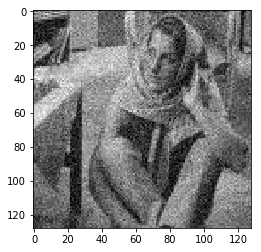

In [23]:
resultImgFolder = "TMP_1217"
#%% 資料讀取與顯示
initailDict = np.load("dct_64_256.npy")
noiseImgName = "noise_barbara_var0.004.jpg"
originalImgName = "original_128x128_barbara.jpg"
noiseImg = cv2.imread(noiseImgName, cv2.IMREAD_GRAYSCALE)
originalImg = cv2.imread(originalImgName)
# cv2.imshow("noise image", noiseImg)
# cv2.imshow("original image", originalImg)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(noiseImg, cmap = "gray")
# plt.imshow(originalImg, cmap = "gray")
plt.show()

### 切片 與 Rij 計算

In [24]:
#%% 切片 - 設置
_rows_patch, _cols_patch = 8,8
_rows, _cols = noiseImg.shape[:2]
_I = _cols - _cols_patch + 1
_J = _rows - _rows_patch + 1
X_img = np.zeros((_cols_patch * _rows_patch, \
                  _I * _J))
print(X_img.shape)

(64, 14641)


In [25]:
#%% 切片執行 與 Rij 計算
# Rij
# Rij_BIG = np.zeros((_I, _J, _rows_patch*_cols_patch, _rows*_cols), dtype = np.bool) # if not bool, need 56 GB, and memory error
Rij_Progressive = np.zeros((_rows, _cols))
# 切片
count = 0 # _i*_I + _j 或這樣算
for _i in range(_I): # _I = _cols - _cols_patch
    for _j in range(_J): # _J = _rows - _rows_patch
        # 切片
        tmpImg =  noiseImg[_i:_i+_cols_patch, _j:_j+_rows_patch].flatten(order="F")
        X_img[:, count] = tmpImg.copy()
        # 計算 Rij
        Rij_Progressive[_i:_i+_cols_patch, _j:_j+_rows_patch] += 1
#         _r = 0
#         for _i_tmp in range(_i, _i + _cols_patch):
#             for _j_tmp in range(_j, _j + _rows_patch):
# #                 Rij_BIG[_i, _j, _r, _i_tmp * _cols_patch + _j_tmp] = 1
#                 Rij_Progressive[_i_tmp, _j_tmp] += 1
#                 _r += 1
        count += 1

### 執行

In [26]:
#%%
_startTime = time.time()
D = initailDict.copy()
# 
_count_time = 0
SP = OMP_SVD(D, X_img, 6)
#for _count_time in range(10):

D: shape (64, 256) mean: There are 256 atoms with length 64
X: shape (64, 14641) mean: There are 14641 signals with length 64
A: shape will be (256, 14641)


In [ ]:
_startTime_while = time.time()
while _count_time < 200:
    print("\ntime:", _count_time)
    print("cal aplpha")
    A = SP.Flow_all_OMP(boolProgressShow = True)
    
    print("\nRebuild-", _count_time)
    x = Rebuild(noiseImg, Rij_Progressive, A, D, _I, _J, _cols_patch, _rows_patch)
    cv2.imwrite( resultImgFolder + "/"+"result"+str(_count_time)+".jpg", x)
    
    print("\ncal dictionary")
    D = SP.UpdateDict_FLOW(boolProgressShow = True)
    
    _count_time += 1

In [28]:
_endTime_while = time.time()
print(_endTime_while - _startTime, "秒過去了")
print("Loop cost", _endTime_while - _startTime_while, "sec.")

20426.071223258972 秒過去了
Loop cost 20426.055267095566 sec.


In [29]:
A = SP.Flow_all_OMP()

In [30]:
np.save("D_"+str(_count_time)+".npy", D)
np.save("A_"+str(_count_time)+".npy", A)

### 重建

In [31]:
x = Rebuild(noiseImg, Rij_Progressive, A, D, _I, _J, _cols_patch, _rows_patch)
cv2.imwrite( resultImgFolder + "/"+"result"+"_END"+".jpg", x)

True

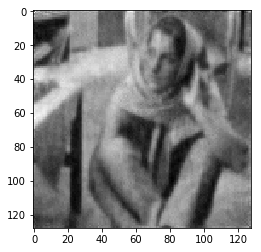

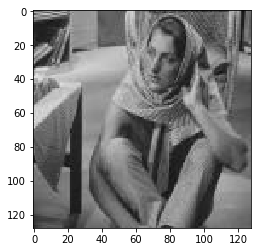

In [32]:
plt.imshow(x , cmap = "gray")
plt.show()
plt.imshow(originalImg, cmap = "gray")
plt.show()